### References:
- https://medium.com/@awjuliani/simple-reinforcement-learning-with-tensorflow-part-3-model-based-rl-9a6fe0cce99

# Model-Based RL

![](../docs/assets/rl/model_based_rl.png)

**What is a model and why would we want to use one?** 
- In this case, a model is going to be a neural network that attempts to learn the dynamics of the real environment. 

For example, in the CartPole we would like a model to be able to predict the next position of the Cart given the previous position and an action. By learning an accurate model, we can train our agent using the model rather than requiring to use the real environment every time. While this may seem less useful when the real environment is itself a simulation, like in our CartPole task, it can have huge advantages when attempting to learn policies for acting in the physical world.

Unlike in computer simulations, physical environments take time to navigate, and the physical rules of the world prevent things like easy environment resets from being feasible. Instead, we can save time and energy by building a model of the environment. With such a model, an agent can ‘imagine’ what it might be like to move around the real environment, and we can train a policy on this imagined environment in addition to the real one. If we were given a good enough model of an environment, an agent could be trained entirely on that model, and even perform well when placed into a real environment for the first time.

How are we going to accomplish this in Tensorflow? As I mentioned above, we are going to be using a neural network that will learn the transition dynamics between a previous observation and action, and the expected new observation, reward, and done state. Our training procedure will involve switching between training our model using the real environment, and training our agent’s policy using the model environment. By using this approach we will be able to learn a policy that allows our agent to solve the CartPole task without actually ever training the policy on the real environment!




In [1]:
import numpy as np
import pickle
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import math

# from modelAny import *

from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import embedding_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn_ops
from tensorflow.python.ops import rnn
# from tensorflow.python.ops import rnn_cell
from tensorflow.python.ops import variable_scope

try:
    xrange = xrange
except:
    xrange = range

/home/mageswarand/anaconda3/envs/tensorflow1.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
import gym
env = gym.make('CartPole-v0')

[2017-12-18 12:00:29,961] Making new env: CartPole-v0


### Setting Hyper-parameters

In [3]:
# hyperparameters
H = 8 # number of hidden layer neurons
learning_rate = 1e-2
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?

model_bs = 3 # Batch size when learning from model
real_bs = 3 # Batch size when learning from real environment

# model initialization
D = 4 # input dimensionality

### Policy Network

In [4]:
tf.reset_default_graph()
observations = tf.placeholder(tf.float32, [None,4] , name="input_x")
W1 = tf.get_variable("W1", shape=[4, H],
           initializer=tf.contrib.layers.xavier_initializer())
layer1 = tf.nn.relu(tf.matmul(observations,W1))
W2 = tf.get_variable("W2", shape=[H, 1],
           initializer=tf.contrib.layers.xavier_initializer())
score = tf.matmul(layer1,W2)
probability = tf.nn.sigmoid(score)

tvars = tf.trainable_variables()
input_y = tf.placeholder(tf.float32,[None,1], name="input_y")
advantages = tf.placeholder(tf.float32,name="reward_signal")
adam = tf.train.AdamOptimizer(learning_rate=learning_rate)
W1Grad = tf.placeholder(tf.float32,name="batch_grad1")
W2Grad = tf.placeholder(tf.float32,name="batch_grad2")
batchGrad = [W1Grad,W2Grad]
loglik = tf.log(input_y*(input_y - probability) + (1 - input_y)*(input_y + probability))
loss = -tf.reduce_mean(loglik * advantages) 
newGrads = tf.gradients(loss,tvars)
updateGrads = adam.apply_gradients(zip(batchGrad,tvars))

### Model Network
Here we implement a multi-layer neural network that predicts the next observation, reward, and done state from a current state and action.

In [5]:
mH = 256 # model layer size

input_data = tf.placeholder(tf.float32, [None, 5])
with tf.variable_scope('rnnlm'):
    softmax_w = tf.get_variable("softmax_w", [mH, 50])
    softmax_b = tf.get_variable("softmax_b", [50])

previous_state = tf.placeholder(tf.float32, [None,5] , name="previous_state")
W1M = tf.get_variable("W1M", shape=[5, mH],
           initializer=tf.contrib.layers.xavier_initializer())
B1M = tf.Variable(tf.zeros([mH]),name="B1M")
layer1M = tf.nn.relu(tf.matmul(previous_state,W1M) + B1M)
W2M = tf.get_variable("W2M", shape=[mH, mH],
           initializer=tf.contrib.layers.xavier_initializer())
B2M = tf.Variable(tf.zeros([mH]),name="B2M")
layer2M = tf.nn.relu(tf.matmul(layer1M,W2M) + B2M)
wO = tf.get_variable("wO", shape=[mH, 4],
           initializer=tf.contrib.layers.xavier_initializer())
wR = tf.get_variable("wR", shape=[mH, 1],
           initializer=tf.contrib.layers.xavier_initializer())
wD = tf.get_variable("wD", shape=[mH, 1],
           initializer=tf.contrib.layers.xavier_initializer())

bO = tf.Variable(tf.zeros([4]),name="bO")
bR = tf.Variable(tf.zeros([1]),name="bR")
bD = tf.Variable(tf.ones([1]),name="bD")


predicted_observation = tf.matmul(layer2M,wO,name="predicted_observation") + bO
predicted_reward = tf.matmul(layer2M,wR,name="predicted_reward") + bR
predicted_done = tf.sigmoid(tf.matmul(layer2M,wD,name="predicted_done") + bD)

true_observation = tf.placeholder(tf.float32,[None,4],name="true_observation")
true_reward = tf.placeholder(tf.float32,[None,1],name="true_reward")
true_done = tf.placeholder(tf.float32,[None,1],name="true_done")


predicted_state = tf.concat([predicted_observation,predicted_reward,predicted_done],1)

observation_loss = tf.square(true_observation - predicted_observation)

reward_loss = tf.square(true_reward - predicted_reward)

done_loss = tf.multiply(predicted_done, true_done) + tf.multiply(1-predicted_done, 1-true_done)
done_loss = -tf.log(done_loss)

model_loss = tf.reduce_mean(observation_loss + done_loss + reward_loss)

modelAdam = tf.train.AdamOptimizer(learning_rate=learning_rate)
updateModel = modelAdam.minimize(model_loss)

### Helper-functions

In [6]:
def resetGradBuffer(gradBuffer):
    for ix,grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0
    return gradBuffer
        
def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(xrange(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r


# This function uses our model to produce a new state when given a previous state and action
def stepModel(sess, xs, action):
    toFeed = np.reshape(np.hstack([xs[-1][0],np.array(action)]),[1,5])
    myPredict = sess.run([predicted_state],feed_dict={previous_state: toFeed})
    reward = myPredict[0][:,4]
    observation = myPredict[0][:,0:4]
    observation[:,0] = np.clip(observation[:,0],-2.4,2.4)
    observation[:,2] = np.clip(observation[:,2],-0.4,0.4)
    doneP = np.clip(myPredict[0][:,5],0,1)
    if doneP > 0.1 or len(xs)>= 300:
        done = True
    else:
        done = False
    return observation, reward, done

### Training the Policy and Model

In [7]:
xs,drs,ys,ds = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 1
real_episodes = 1
init = tf.initialize_all_variables()
batch_size = real_bs

drawFromModel = False # When set to True, will use model for observations
trainTheModel = True # Whether to train the model
trainThePolicy = False # Whether to train the policy
switch_point = 1

# Launch the graph
with tf.Session() as sess:
    rendering = False
    sess.run(init)
    observation = env.reset()
    x = observation
    gradBuffer = sess.run(tvars)
    gradBuffer = resetGradBuffer(gradBuffer)
    
    while episode_number <= 5000:
        # Start displaying environment once performance is acceptably high.
        if (reward_sum/batch_size > 150 and drawFromModel == False) or rendering == True : 
            env.render()
            rendering = True
            
        x = np.reshape(observation,[1,4])

        tfprob = sess.run(probability,feed_dict={observations: x})
        action = 1 if np.random.uniform() < tfprob else 0

        # record various intermediates (needed later for backprop)
        xs.append(x) 
        y = 1 if action == 0 else 0 
        ys.append(y)
        
        # step the  model or real environment and get new measurements
        if drawFromModel == False:
            observation, reward, done, info = env.step(action)
        else:
            observation, reward, done = stepModel(sess,xs,action)
                
        reward_sum += reward
        
        ds.append(done*1)
        drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

        if done: 
            
            if drawFromModel == False: 
                real_episodes += 1
            episode_number += 1

            # stack together all inputs, hidden states, action gradients, and rewards for this episode
            epx = np.vstack(xs)
            epy = np.vstack(ys)
            epr = np.vstack(drs)
            epd = np.vstack(ds)
            xs,drs,ys,ds = [],[],[],[] # reset array memory
            
            if trainTheModel == True:
                actions = np.array([np.abs(y-1) for y in epy][:-1])
                state_prevs = epx[:-1,:]
                state_prevs = np.hstack([state_prevs,actions])
                state_nexts = epx[1:,:]
                rewards = np.array(epr[1:,:])
                dones = np.array(epd[1:,:])
                state_nextsAll = np.hstack([state_nexts,rewards,dones])

                feed_dict={previous_state: state_prevs, true_observation: state_nexts,true_done:dones,true_reward:rewards}
                loss,pState,_ = sess.run([model_loss,predicted_state,updateModel],feed_dict)
            if trainThePolicy == True:
                discounted_epr = discount_rewards(epr).astype('float32')
                discounted_epr -= np.mean(discounted_epr)
                discounted_epr /= np.std(discounted_epr)
                tGrad = sess.run(newGrads,feed_dict={observations: epx, input_y: epy, advantages: discounted_epr})
                
                # If gradients becom too large, end training process
                if np.sum(tGrad[0] == tGrad[0]) == 0:
                    break
                for ix,grad in enumerate(tGrad):
                    gradBuffer[ix] += grad
                
            if switch_point + batch_size == episode_number: 
                switch_point = episode_number
                if trainThePolicy == True:
                    sess.run(updateGrads,feed_dict={W1Grad: gradBuffer[0],W2Grad:gradBuffer[1]})
                    gradBuffer = resetGradBuffer(gradBuffer)

                running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
                if drawFromModel == False:
                    print ('World Perf: Episode %f. Reward %f. action: %f. mean reward %f.' % (real_episodes,reward_sum/real_bs,action, running_reward/real_bs))
                    if reward_sum/batch_size > 200:
                        break
                reward_sum = 0

                # Once the model has been trained on 100 episodes, we start alternating between training the policy
                # from the model and training the model from the real environment.
                if episode_number > 100:
                    drawFromModel = not drawFromModel
                    trainTheModel = not trainTheModel
                    trainThePolicy = not trainThePolicy
            
            if drawFromModel == True:
                observation = np.random.uniform(-0.1,0.1,[4]) # Generate reasonable starting point
                batch_size = model_bs
            else:
                observation = env.reset()
                batch_size = real_bs
                

Instructions for updating:
Use `tf.global_variables_initializer` instead.


[2017-12-18 12:00:32,546] From /home/mageswarand/anaconda3/envs/tensorflow1.0/lib/python3.6/site-packages/tensorflow/python/util/tf_should_use.py:107: initialize_all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


World Perf: Episode 4.000000. Reward 31.333333. action: 1.000000. mean reward 31.333333.
World Perf: Episode 7.000000. Reward 30.333333. action: 0.000000. mean reward 31.323333.
World Perf: Episode 10.000000. Reward 17.000000. action: 0.000000. mean reward 31.180100.
World Perf: Episode 13.000000. Reward 36.333333. action: 1.000000. mean reward 31.231632.
World Perf: Episode 16.000000. Reward 43.000000. action: 1.000000. mean reward 31.349316.
World Perf: Episode 19.000000. Reward 14.333333. action: 0.000000. mean reward 31.179156.
World Perf: Episode 22.000000. Reward 43.666667. action: 1.000000. mean reward 31.304031.
World Perf: Episode 25.000000. Reward 22.000000. action: 0.000000. mean reward 31.210991.
World Perf: Episode 28.000000. Reward 39.000000. action: 0.000000. mean reward 31.288881.
World Perf: Episode 31.000000. Reward 28.000000. action: 1.000000. mean reward 31.255992.
World Perf: Episode 34.000000. Reward 19.000000. action: 0.000000. mean reward 31.133432.
World Perf: 

World Perf: Episode 277.000000. Reward 30.333333. action: 0.000000. mean reward 46.592793.
World Perf: Episode 280.000000. Reward 51.000000. action: 1.000000. mean reward 49.664700.
World Perf: Episode 283.000000. Reward 31.666667. action: 1.000000. mean reward 51.876179.
World Perf: Episode 286.000000. Reward 48.000000. action: 1.000000. mean reward 51.507053.
World Perf: Episode 289.000000. Reward 40.666667. action: 1.000000. mean reward 51.116226.
World Perf: Episode 292.000000. Reward 32.333333. action: 1.000000. mean reward 52.160641.
World Perf: Episode 295.000000. Reward 44.000000. action: 0.000000. mean reward 51.836872.
World Perf: Episode 298.000000. Reward 29.666667. action: 1.000000. mean reward 51.237076.
World Perf: Episode 301.000000. Reward 27.000000. action: 1.000000. mean reward 50.576519.
World Perf: Episode 304.000000. Reward 83.333333. action: 1.000000. mean reward 52.399189.
World Perf: Episode 307.000000. Reward 30.000000. action: 0.000000. mean reward 51.800640.

World Perf: Episode 538.000000. Reward 73.000000. action: 0.000000. mean reward 735610404864.000000.
World Perf: Episode 541.000000. Reward 54.666667. action: 1.000000. mean reward 720971759616.000000.
World Perf: Episode 544.000000. Reward 96.333333. action: 0.000000. mean reward 706624421888.000000.
World Perf: Episode 547.000000. Reward 73.000000. action: 1.000000. mean reward 692562624512.000000.
World Perf: Episode 550.000000. Reward 43.666667. action: 1.000000. mean reward 678780665856.000000.
World Perf: Episode 553.000000. Reward 95.000000. action: 0.000000. mean reward 665272909824.000000.
World Perf: Episode 556.000000. Reward 88.666667. action: 0.000000. mean reward 652033982464.000000.
World Perf: Episode 559.000000. Reward 76.000000. action: 1.000000. mean reward 639058509824.000000.
World Perf: Episode 562.000000. Reward 90.333333. action: 0.000000. mean reward 626341249024.000000.
World Perf: Episode 565.000000. Reward 90.666667. action: 0.000000. mean reward 61387708825

World Perf: Episode 781.000000. Reward 112.666667. action: 1.000000. mean reward 144394305536.000000.
World Perf: Episode 784.000000. Reward 124.333333. action: 0.000000. mean reward 141520863232.000000.
World Perf: Episode 787.000000. Reward 142.333333. action: 0.000000. mean reward 138704601088.000000.
World Perf: Episode 790.000000. Reward 134.333333. action: 1.000000. mean reward 135944380416.000000.
World Perf: Episode 793.000000. Reward 169.333333. action: 0.000000. mean reward 133239087104.000000.
World Perf: Episode 796.000000. Reward 116.000000. action: 0.000000. mean reward 130587631616.000000.
World Perf: Episode 799.000000. Reward 132.333333. action: 0.000000. mean reward 127988948992.000000.
World Perf: Episode 802.000000. Reward 126.333333. action: 1.000000. mean reward 125441974272.000000.
World Perf: Episode 805.000000. Reward 162.666667. action: 0.000000. mean reward 122945691648.000000.
World Perf: Episode 808.000000. Reward 152.000000. action: 0.000000. mean reward 1

World Perf: Episode 1024.000000. Reward 187.000000. action: 1.000000. mean reward 28343427072.000000.
World Perf: Episode 1027.000000. Reward 200.000000. action: 0.000000. mean reward 27779391488.000000.
World Perf: Episode 1030.000000. Reward 200.000000. action: 0.000000. mean reward 27226580992.000000.
World Perf: Episode 1033.000000. Reward 200.000000. action: 0.000000. mean reward 26684770304.000000.
World Perf: Episode 1036.000000. Reward 200.000000. action: 0.000000. mean reward 26153746432.000000.
World Perf: Episode 1039.000000. Reward 180.333333. action: 1.000000. mean reward 25633286144.000000.
World Perf: Episode 1042.000000. Reward 200.000000. action: 1.000000. mean reward 25123184640.000000.
World Perf: Episode 1045.000000. Reward 200.000000. action: 0.000000. mean reward 24623233024.000000.
World Perf: Episode 1048.000000. Reward 200.000000. action: 1.000000. mean reward 24133230592.000000.
World Perf: Episode 1051.000000. Reward 193.333333. action: 0.000000. mean reward 

World Perf: Episode 1267.000000. Reward 200.000000. action: 0.000000. mean reward 5563581952.000000.
World Perf: Episode 1270.000000. Reward 200.000000. action: 0.000000. mean reward 5452867072.000000.
World Perf: Episode 1273.000000. Reward 200.000000. action: 0.000000. mean reward 5344354816.000000.
World Perf: Episode 1276.000000. Reward 195.333333. action: 0.000000. mean reward 5238002176.000000.
World Perf: Episode 1279.000000. Reward 200.000000. action: 1.000000. mean reward 5133766144.000000.
World Perf: Episode 1282.000000. Reward 200.000000. action: 1.000000. mean reward 5031604736.000000.
World Perf: Episode 1285.000000. Reward 200.000000. action: 1.000000. mean reward 4931475968.000000.
World Perf: Episode 1288.000000. Reward 200.000000. action: 0.000000. mean reward 4833339392.000000.
World Perf: Episode 1291.000000. Reward 200.000000. action: 0.000000. mean reward 4737155584.000000.
World Perf: Episode 1294.000000. Reward 200.000000. action: 0.000000. mean reward 464288614

World Perf: Episode 1513.000000. Reward 200.000000. action: 1.000000. mean reward 1070353344.000000.
World Perf: Episode 1516.000000. Reward 200.000000. action: 1.000000. mean reward 1049053248.000000.
World Perf: Episode 1519.000000. Reward 181.000000. action: 0.000000. mean reward 1028177152.000000.
World Perf: Episode 1522.000000. Reward 200.000000. action: 1.000000. mean reward 1007716416.000000.
World Perf: Episode 1525.000000. Reward 200.000000. action: 0.000000. mean reward 987662848.000000.
World Perf: Episode 1528.000000. Reward 200.000000. action: 0.000000. mean reward 968008384.000000.
World Perf: Episode 1531.000000. Reward 200.000000. action: 0.000000. mean reward 948745024.000000.
World Perf: Episode 1534.000000. Reward 200.000000. action: 0.000000. mean reward 929865024.000000.
World Perf: Episode 1537.000000. Reward 200.000000. action: 1.000000. mean reward 911360768.000000.
World Perf: Episode 1540.000000. Reward 200.000000. action: 0.000000. mean reward 893224704.0000

World Perf: Episode 1759.000000. Reward 200.000000. action: 0.000000. mean reward 205920576.000000.
World Perf: Episode 1762.000000. Reward 200.000000. action: 0.000000. mean reward 201822768.000000.
World Perf: Episode 1765.000000. Reward 200.000000. action: 0.000000. mean reward 197806512.000000.
World Perf: Episode 1768.000000. Reward 200.000000. action: 1.000000. mean reward 193870160.000000.
World Perf: Episode 1771.000000. Reward 200.000000. action: 0.000000. mean reward 190012144.000000.
World Perf: Episode 1774.000000. Reward 200.000000. action: 1.000000. mean reward 186230912.000000.
World Perf: Episode 1777.000000. Reward 200.000000. action: 0.000000. mean reward 182524912.000000.
World Perf: Episode 1780.000000. Reward 200.000000. action: 0.000000. mean reward 178892672.000000.
World Perf: Episode 1783.000000. Reward 200.000000. action: 1.000000. mean reward 175332704.000000.
World Perf: Episode 1786.000000. Reward 200.000000. action: 1.000000. mean reward 171843584.000000.


World Perf: Episode 2008.000000. Reward 200.000000. action: 0.000000. mean reward 38827920.000000.
World Perf: Episode 2011.000000. Reward 200.000000. action: 0.000000. mean reward 38055248.000000.
World Perf: Episode 2014.000000. Reward 200.000000. action: 1.000000. mean reward 37297956.000000.
World Perf: Episode 2017.000000. Reward 200.000000. action: 0.000000. mean reward 36555728.000000.
World Perf: Episode 2020.000000. Reward 200.000000. action: 1.000000. mean reward 35828276.000000.
World Perf: Episode 2023.000000. Reward 200.000000. action: 0.000000. mean reward 35115300.000000.
World Perf: Episode 2026.000000. Reward 200.000000. action: 1.000000. mean reward 34416508.000000.
World Perf: Episode 2029.000000. Reward 200.000000. action: 0.000000. mean reward 33731628.000000.
World Perf: Episode 2032.000000. Reward 200.000000. action: 1.000000. mean reward 33060370.000000.
World Perf: Episode 2035.000000. Reward 200.000000. action: 0.000000. mean reward 32402474.000000.
World Perf

World Perf: Episode 2257.000000. Reward 200.000000. action: 0.000000. mean reward 7321468.500000.
World Perf: Episode 2260.000000. Reward 200.000000. action: 1.000000. mean reward 7175776.000000.
World Perf: Episode 2263.000000. Reward 200.000000. action: 0.000000. mean reward 7032983.500000.
World Perf: Episode 2266.000000. Reward 200.000000. action: 0.000000. mean reward 6893031.500000.
World Perf: Episode 2269.000000. Reward 200.000000. action: 1.000000. mean reward 6755866.000000.
World Perf: Episode 2272.000000. Reward 200.000000. action: 0.000000. mean reward 6621426.500000.
World Perf: Episode 2275.000000. Reward 200.000000. action: 0.000000. mean reward 6489665.500000.
World Perf: Episode 2278.000000. Reward 200.000000. action: 0.000000. mean reward 6360526.500000.
World Perf: Episode 2281.000000. Reward 200.000000. action: 1.000000. mean reward 6233957.500000.
World Perf: Episode 2284.000000. Reward 200.000000. action: 1.000000. mean reward 6109907.500000.
World Perf: Episode 

KeyboardInterrupt: 

### Checking model representation
Here we can examine how well the model is able to approximate the true environment after training. The green line indicates the real environment, and the blue indicates model predictions.

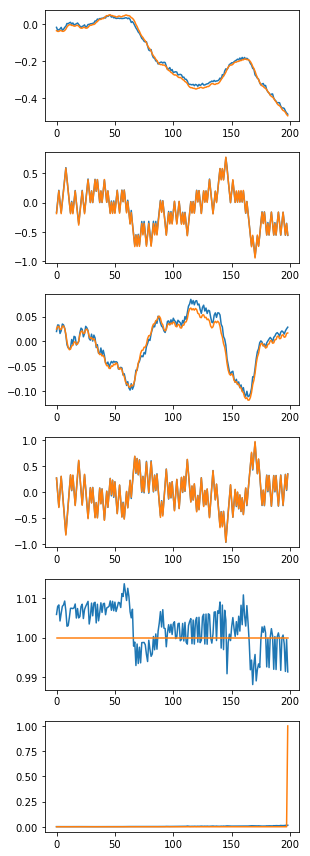

In [8]:
plt.figure(figsize=(8, 12))
for i in range(6):
    plt.subplot(6, 2, 2*i + 1)
    plt.plot(pState[:,i])
    plt.subplot(6,2,2*i+1)
    plt.plot(state_nextsAll[:,i])
plt.tight_layout()